# PyTorch3D Tutorial - \#1  Loss Terms
This is a simple notebook following the [official PyTorch3D Tutorial](https://pytorch3d.org/tutorials/).

In the notebook, I follow mostly the original tutorial to use a loss function to make an initial ico-sphere mesh to learn (deform) into the target shape of a dolphin, through gradient descent.

In addition, I also play around with the 4 loss terms `chamfer_distance`, `mesh_edge_length`, `mesh_normal_consistency`, and `mesh_laplacian_smoothing`, and quantitatively visualise how the loss terms affect the final output mesh.

In [5]:
import torch
import pytorch3d

C:\Users\iycsp\.conda\envs\pytorch3d\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
import os
import torch
from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import Meshes
from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)

In [7]:
from tqdm import tqdm

In [9]:
# Set the device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("GPU is used.")
else:
    device = torch.device("cpu")
    print("WARNING: CPU only, this will be slow!")

GPU is used.


In [10]:
dolphin_path = 'C:/Users/iycsp/Desktop/UROP/urop-experimental/pytorch3d-tutorial/datasets/dolphin.obj'

In [11]:
# We read the target 3D model using load_obj
verts, faces, aux = load_obj(dolphin_path)

# verts is a FloatTensor of shape (V, 3) where V is the number of vertices in the mesh
# faces is an object which contains the following LongTensors: verts_idx, normals_idx and textures_idx
# For this tutorial, normals and textures are ignored.
faces_idx = faces.verts_idx.to(device)
verts = verts.to(device)

# We scale normalize and center the target mesh to fit in a sphere of radius 1 centered at (0,0,0). 
# (scale, center) will be used to bring the predicted mesh to its original center and scale
# Note that normalizing the target mesh, speeds up the optimization but is not necessary!
center = verts.mean(0)
verts = verts - center
scale = max(verts.abs().max(0)[0])
verts = verts / scale

# We construct a Meshes structure for the target mesh
trg_mesh = Meshes(verts=[verts], faces=[faces_idx])

C:\Users\iycsp\.conda\envs\pytorch3d\lib\site-packages\pytorch3d\io\obj_io.py:529: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


In [12]:
src_mesh = ico_sphere(4, device)

C:\Users\iycsp\.conda\envs\pytorch3d\lib\site-packages\pytorch3d\structures\meshes.py:1107: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  self._edges_packed = torch.stack([u // V, u % V], dim=1)


In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook 

In [17]:
def plot_pointcloud(mesh, sample_num=5000, title=""):
    # Sample points uniformly from the surface of the mesh.
    points = sample_points_from_meshes(mesh, sample_num)
    x, y, z = points.clone().detach().cpu().squeeze().unbind(1)    
    fig = plt.figure(figsize=(5, 5))
    ax=fig.add_subplot(111,projection='3d')
    ax.scatter3D(x, z, -y)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    ax.view_init(190, 30)
    plt.show()

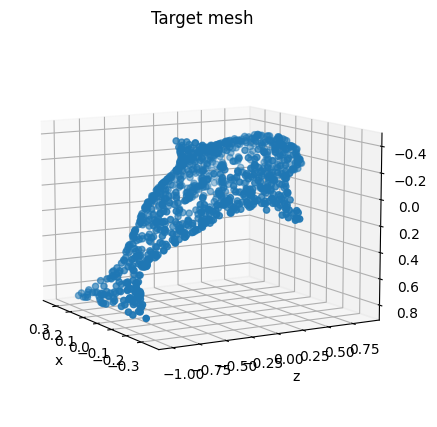

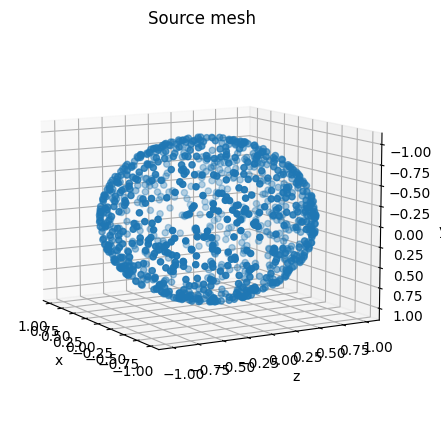

In [20]:
# %matplotlib notebook
plot_pointcloud(trg_mesh, sample_num=1000, title="Target mesh")
plot_pointcloud(src_mesh, sample_num=1000, title="Source mesh")

## Train & Experiment Loss terms
The following code are run multiple times, by changing the coefficients for the different loss terms, and the final meshes are saved to different `.obj` files.

| Name               | Chamfer | Edge | Normal | Laplacian | N_iter |
|--------------------|---------|------|--------|-----------|--------|
| fitter             | 1.0     | 1.0  | 0.01   | 0.1       | 2000   |
| fitted_500_iter    | 1.0     | 1.0  | 0.01   | 0.1       | 500    |
| fitted_no_chamfer  | 0       | 1.0  | 0.01   | 0.1       | 2000   |
| fitted_0.2_chamfer | 0.2     | 1.0  | 0.01   | 0.1       | 2000   |
| fitted_no_edge     | 1.0     | 0    | 0.01   | 0.1       | 2000   |
| fitted_no_normal   | 1.0     | 1.0  | 0      | 0.1       | 2000   |
| fitted_no_lap      | 1.0     | 1.0  | 0.01   | 0         | 2000   |

In [22]:
# We will learn to deform the source mesh by offsetting its vertices
src_mesh = ico_sphere(4, device)

C:\Users\iycsp\.conda\envs\pytorch3d\lib\site-packages\pytorch3d\structures\meshes.py:1107: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  self._edges_packed = torch.stack([u // V, u % V], dim=1)


In [23]:
# Number of optimization steps
Niter = 2000
# Weight for the chamfer loss
w_chamfer = 1.0
# Weight for mesh edge loss
w_edge = 1.0
# Weight for mesh normal consistency
w_normal = 0.01 
# Weight for mesh laplacian smoothing
w_laplacian = 0.1 

In [24]:
# The shape of the deform parameters is equal to the total number of vertices in src_mesh
deform_verts = torch.full(src_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)

# The optimizer
optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)

In [25]:
plot_period = 250
loop = tqdm(range(Niter))

chamfer_losses = []
laplacian_losses = []
edge_losses = []
normal_losses = []

%matplotlib inline

for i in loop:
    # Initialize optimizer
    optimizer.zero_grad()
    
    # Deform the mesh
    new_src_mesh = src_mesh.offset_verts(deform_verts)
    
    # We sample 5k points from the surface of each mesh 
    sample_trg = sample_points_from_meshes(trg_mesh, 5000)
    sample_src = sample_points_from_meshes(new_src_mesh, 5000)
    
    # We compare the two sets of pointclouds by computing (a) the chamfer loss
    loss_chamfer, _ = chamfer_distance(sample_trg, sample_src)
    
    # and (b) the edge length of the predicted mesh
    loss_edge = mesh_edge_loss(new_src_mesh)
    
    # mesh normal consistency
    loss_normal = mesh_normal_consistency(new_src_mesh)
    
    # mesh laplacian smoothing
    loss_laplacian = mesh_laplacian_smoothing(new_src_mesh, method="uniform")
    
    # Weighted sum of the losses
    loss = loss_chamfer * w_chamfer + loss_edge * w_edge + loss_normal * w_normal + loss_laplacian * w_laplacian
    
    # Print the losses
    loop.set_description('total_loss = %.6f' % loss)
    
    # Save the losses for plotting
    chamfer_losses.append(float(loss_chamfer.detach().cpu()))
    edge_losses.append(float(loss_edge.detach().cpu()))
    normal_losses.append(float(loss_normal.detach().cpu()))
    laplacian_losses.append(float(loss_laplacian.detach().cpu()))
    
    # Optimization step
    loss.backward()
    optimizer.step()

total_loss = 0.002830: 100%|███████████████████████████████████████████████████████| 2000/2000 [00:36<00:00, 54.84it/s]


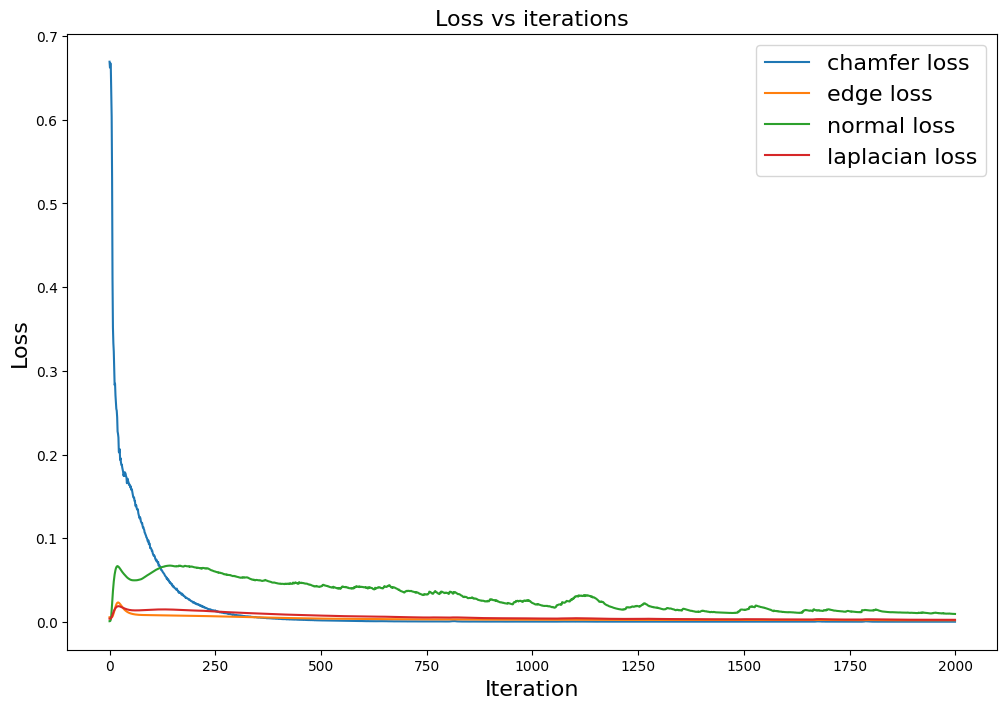

In [26]:
fig = plt.figure(figsize=(12, 8))
ax = fig.gca()
ax.plot(chamfer_losses, label="chamfer loss")
ax.plot(edge_losses, label="edge loss")
ax.plot(normal_losses, label="normal loss")
ax.plot(laplacian_losses, label="laplacian loss")
ax.legend(fontsize="16")
ax.set_xlabel("Iteration", fontsize="16")
ax.set_ylabel("Loss", fontsize="16")
ax.set_title("Loss vs iterations", fontsize="16");

In [27]:
# Fetch the verts and faces of the final predicted mesh
final_verts, final_faces = new_src_mesh.get_mesh_verts_faces(0)

# Scale normalize back to the original target size
final_verts = final_verts * scale + center

# Store the predicted mesh using save_obj
final_obj = os.path.join('./outputs/', 'fitted.obj')
save_obj(final_obj, final_verts, final_faces)

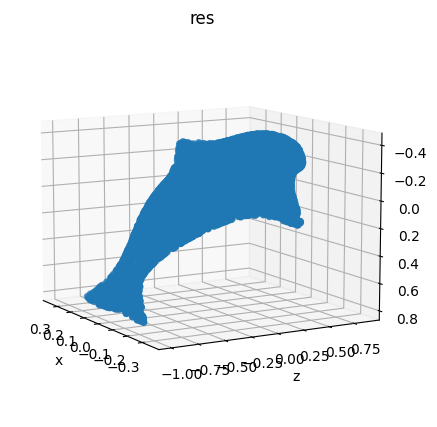

In [29]:
plot_pointcloud(new_src_mesh, title="res")

## Analysis

The image below shows the rendered object of the dolphin meshes, following the order from front to back, left to right for GT and the predicted results with the above 7 loss term variants.

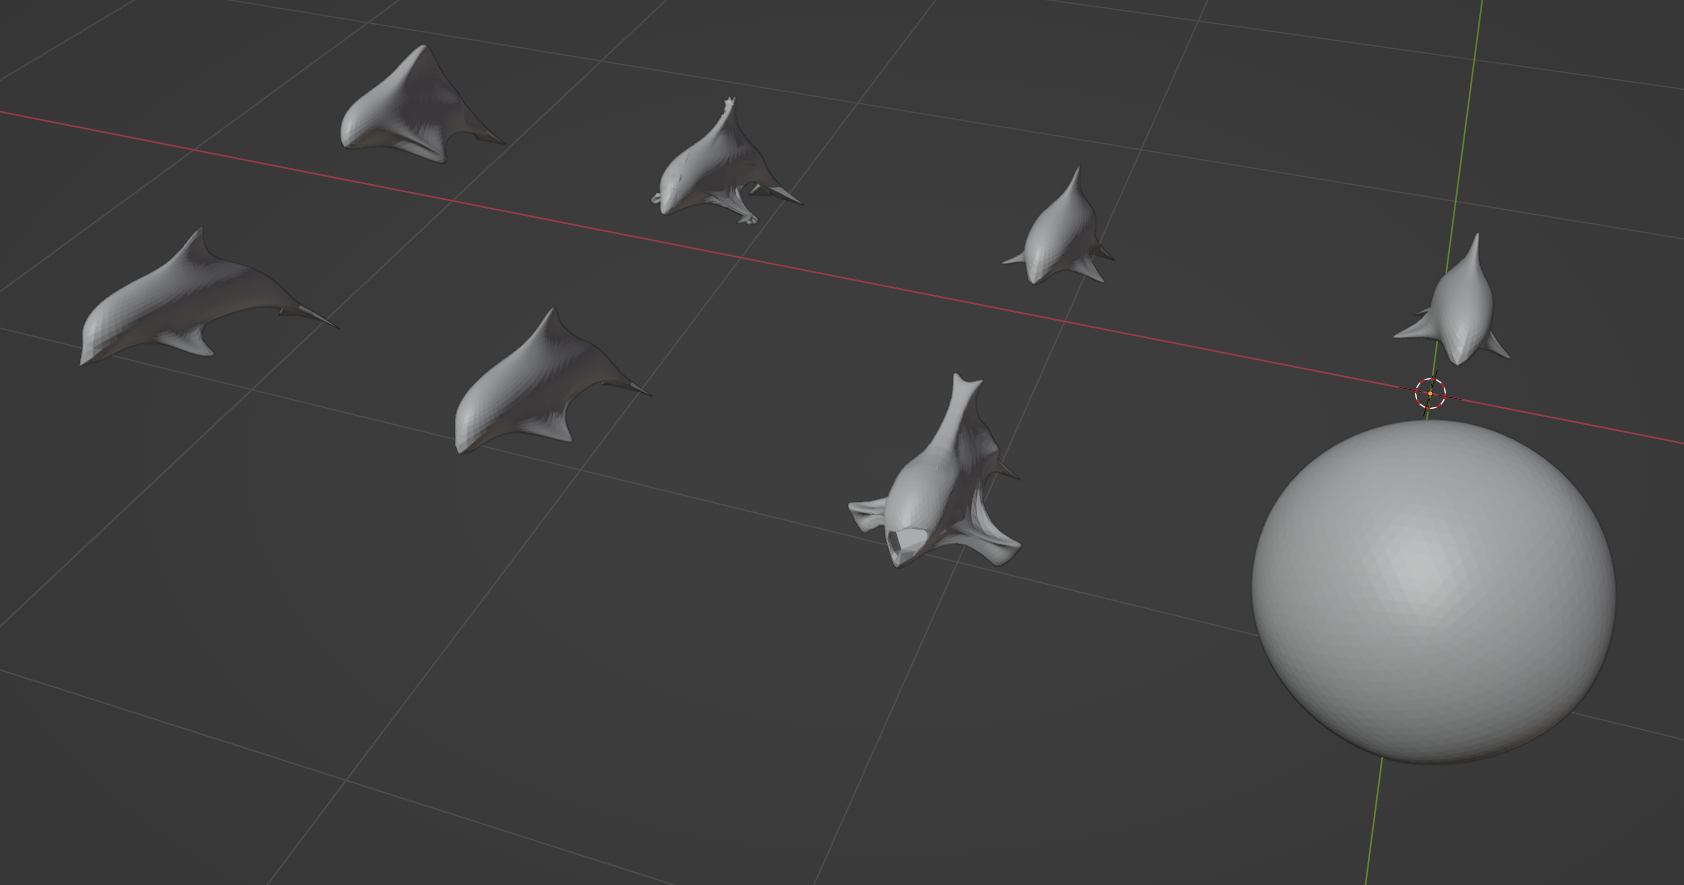

It is evident that Chamfer distance serves as the main term in the loss function. There is no deformation when it is excluded and the shape is very coarse when it is small. For the remaining regularisers, edge length and laplacian regularisers also have some impact on the final shape, while normal consistency has limited impact on the learning.